신호란 시간(시간적 신호) 또는 공간 좌표(공간적 신호)의 함수로 변화하는 수량일 수 있다. 예를 들어 오디오 신호는 시간적 신호의 전형적인 예인 반면, 이미지는 2차원의 공간적 신호의 전형적인 예이다.

신호는 실제로는 연속적인 함수인 경우가 많지만 전산 응용에서는 원래의 연속 신호를 등간격을 가진 이산 지점에서 표본 추출해 이산된 신호로 만들어 작업하는 것이 일반적이다. 샘플링 이론은 연속 신호가 표본 추출된 이산 신호로 정확히 표현될 수 있게 해준다.

# 모듈 임포트하기

In [1]:
from scipy import fftpack
from scipy import signal

# WAV 유형의 오디오 파일 읽고 쓰기
import scipy.io.wavfile
from scipy import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 스펙트럼 분석
스펙트럼 분석은 푸리에 변환의 근본적 응용으로 수학적 적분 변환을 사용해 시간 영역(여기서는 시간 함수라고 표현)에서 기술된 신호를 주파수의 함수로 기술되는 주파수 영역으로 변환하는 것이다.

신호를 주파수 영역으로 나타내면 여러가지 목적상 매우 유용한데 그 예로 신호 중 우세한 주파수 성분 등의 특징 추출, 신호에 필터를 적용, 미분 방정식의 해결(9장 'ODE' 참고) 등이 있다.

## 푸리에 변환
연속 신호 $f(t)$에 대한 푸리에 변환 $F(v)$에 대한 수학 식은 다음과 같다.
$$F(v)=\int_{-\infty}^\infty f(t)e^{-2\pi ivt}dt,$$

역푸리에 변환은 다음과 같다.
$$f(t)=\int_{-\infty}^\infty f(v)e^{2\pi ivt}dv.$$

- $F(v)$: 신호 $f(v)$의 복소수값 진폭 스펙트럼
- $v$: 주파수
- $F(v)$로부터 지수 스펙트럼 $|F(v)|^2$와 같은 다른 스펙트럼 유형도 계산할 수 있음
- $f(t)$: 무한 지속 시간을 갖는 연속 신호

실제 응용에서는 대개 유한 시간 동안의 유한 표본 개수를 이용해 $f(t)$를 근사화하는 것에 더 관심을 둔다. 예를 들어 시간 간격 $t\in [0, T]$에서 $f(t)$ 함수의 $N$개의 표본을 균일한 간격으로 표본 추출하고 그 시퀀스를 $(X_0, x_1, ..., X_N)$로 표기할 수 있다.

앞서 살펴본 연속 푸리에 변환은 이산의 경우로 적용시킬 수 있다. 균일한 간격을 가진 표본 시퀀스의 이산 푸리에 변환은 다음과 같이 나타낼 수 있다.
$$X_k=\sum_{n=0}^{N-1}x_ne^{-2\pi ink/N},$$

또한 역변환은 다음과 같이 정의된다.
$$x_n=\frac1N\sum_{k=0}^{N-1}X_ke^{2\pi ink/N},$$

- $X_k$: 표본 $x_n$의 DFT
- $k$: 실제 주파수와 연계시킬 수 있는 주파수 빈(bin) 번호

표본 시퀀스의 DFT는 FFT로 알려진 알고리즘을 사용해 매우 효과적으로 계산할 수 있다. Scipy fftpack 모듈에는 FFT 알고리즘이 구현돼 있다.

DFT는 이산 표본을 입력으로 취하고 이산 주파수 스펙트럼을 출력한다는 점에 유의하자. 원래 연속인 프로세스에 DFT를 사용하려면 먼저 표본 추출을 통해 신호를 이산값으로 줄여야 한다. 샘플링 이론에 따르면 대역폭 $B$(즉, $B$보다 높은 주파수를 포함하지 않는 신호)를 가진 연속 신호는 샘플링 주파수 $f_s\geq 2B$인 이산 표본으로부터 완벽히 재구성할 수 있다. 샘플링 비율은 DFT로 기술할 수 있는 최대 주파수를 결정하는 반면, 주파수 공간에서의 표본 간격은 표본 주파수가 결정되면 총 샘플링 시간 $T$ 또는 표본 포인트 개수로 결정된다($T=N/f_s$).

정규분포 소음 층의 위에 1Hz와 22Hz의 순수 사인 성분을 가진 시뮬레이션된 신호를 생각해보자. 먼저 이 신호의 잡음 표본을 생성하는 함수 signal_samples를 정의한다.

In [2]:
def signal_samples(t):
    return (2 * np.sin(1 * 2 * np.pi * t) +
            3 * np.sin(22 * 2 * np.pi * t) +
            2 * np.random.randn(*np.shape(t)))

이 함수에 표본 시간 배열을 인수로 전달해 호출하면 표본 벡터를 얻을 수 있다. 이 신호의 주파수 스펙트럼을 30Hz까지 계산하는 데 관심이 있다고 가정해보자. 이제 샘플링 주파수 $f_s=$ 60Hz를 선택해야 하는데 분해능이 $\triangle f=$ 0.01Hz인 주파수 스펙트럼을 얻고자 한다면 적어도 $N=f_s/\triangle f=6000$개의 표본을 수집해야 한다. 이는 표본 주기 $T=N/f_s=100$초에 해당한다.

In [3]:
B = 30.0
f_s = 2 * B            # 60.0
delta_f = 0.01
N = int(f_s / delta_f) # 6000
T = N / f_s            # 100.0

신호 함수를 시간적으로 균일하게 간격을 두고 N번 추출해야 하는데, 먼저 표본 추출 시간을 가진 배열 t를 생성한 후 t를 이용해 signal_samples 함수를 계산한다.

In [4]:
t = np.linspace(0, T, N)
f_t = signal_samples(t)

결과 신호는 아래 그림과 같다. 신호는 전체 샘플링 시간이든 짧은 시간 주기로 보든 다소 잡음이 있어 순수 사인 신호를 가린다.

Text(0.5, 0, 'time (s)')

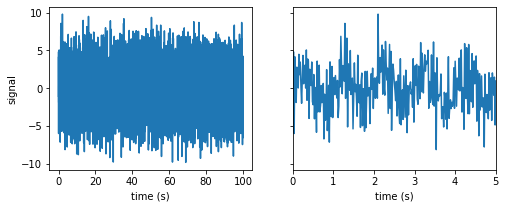

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")

axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")

FFT를 이용해 신호 중 사인 성분을 걸러낼 수 있다. fft 함수를 이산 표본 배열 f_t에 적용하면 신호의 주파수 성분을 얻어낼 수 있다.

In [6]:
F = fftpack.fft(f_t)

주파수를 계산할 때는 헬퍼 함수 fftfreq를 사용하면 편리하다. 매개변수는 표본 개수, 연속된 표본 추출 사이의 지속 시간(샘플링을 할 때 두는 간격)이며 결과 값은 각 주파수 빈(bin)에 해당하는 주파수 값을 가진 F와 같은 크기의 배열을 반환한다.

In [7]:
f = fftpack.fftfreq(N, 1.0/f_s)

fft 함수가 반환한 진폭 값의 주파수 빈에는 샘플링 율의 절반 rate($f_s/2$)에 해당하는 양과 음의 주파수가 들어있다. 실수값 신호의 경우 스펙트럼은 양과 음의 주파수에서 대칭이기 때문에 대개 양의 주파수 성분에만 관심이 있다.

주파수 배열 f를 이용하면 관심있는 주파수 부분만 추출할 수 있는 마스크를 편리하게 만들 수 있다. 아래 코드는 양의 주파수 성분을 걸러내는 마스크를 생성한다.

In [8]:
mask = np.where(f >= 0)

양의 주파수 성분에 대한 스펙트럼은 아래 그림과 같다. 위 패널에는 전체 양의 주파수 스펙트럼이 포함되고 신호와 잡음 대비를 명확히 하기 위해 로그 척도로 도식화했다. 신호의 사인파 성분에 해당하는 1Hz와 22Hz 근처에는 날카로운 피크가 있다는 것을 알 수 있다. 이 피크들은 스펙트럼의 잡음 층에서 뚜렷하게 눈에 띈다. 시간 영역 신호에서 사인파 성분을 은폐히는 잡음에도 불구하고 주파수-영역 표현에서 이들의 존재를 분명히 감지할 수 있다. 그림의 아래 2개 패널은 각각 1Hz와 22Hz에서의 피크의 확대된 모습을보여준다.

Text(0, 0.5, '$|F|/N$')

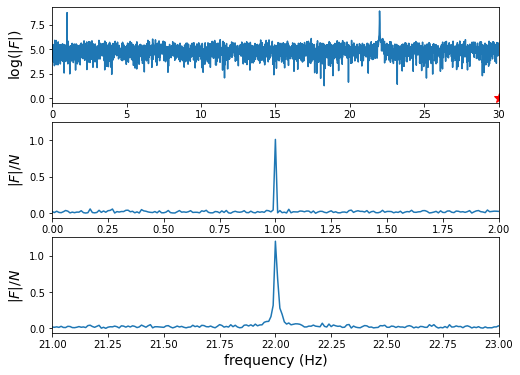

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

axes[0].plot(f[mask], np.log(abs(F[mask])), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_xlim(0, 30)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(f[mask], abs(F[mask])/N, label="real")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|/N$", fontsize=14)

axes[2].plot(f[mask], abs(F[mask])/N, label="real")
axes[2].set_xlim(21, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$|F|/N$", fontsize=14)

### 주파수-영역 필터
FFT 함수 fft를 사용해 시간-영역 신호에서 주파수-영역 표현을 계산할 수 있듯이 역
FFT 함수 ifft 를 이용하면 주파수-영역 표현에서 시간-영역 신호를 계산할 수 있다. 예를 들어 ifft 힘수를 F 배열에 적용하면 f_t 배열을 재구성할 수 있다. 역변환을 적용하기 전에 스펙트럼을 수정하면 주파수-영역 필터를 실현할 수 있다. 예를 들어 스펙트럼에서 2Hz 미만의 주파수만 선택하는 것은 신호에서 고주파 성분(이 경우에는 2Hz 이상)을 억제하는 2Hz 저주파-통과 필터를 적용하는 것과 같다.

In [10]:
F_filtered = F * (abs(f) < 2)
f_t_filtered = fftpack.ifft(F_filtered)

필터링된 신호의 역FFT를 계산하면 아래 그림 같이 고주파 진동이 없는 시간-영역 신호가 생성된다. 이 간단한 예는 많은 주파수-영역 필터의 본질을 요약한다.

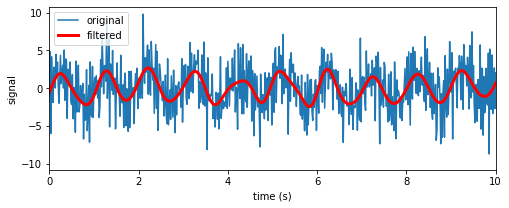

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(t, f_t, label='original')
ax.plot(t, f_t_filtered.real, color="red", lw=3, label='filtered')

ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")

ax.legend()

## 윈도우
앞에서는 FFT를 신호에 직접 적용했다. 그 방법도 나름대로의 결과를 생성하지만 종종 윈도우 함수를 FFT 적용 전에 신호에 적용해 스펙트럼의 품질과 대비를 더욱 개
선할 수 있을 때가 있다. 윈도우 함수란 신호가 곱해지면 크기를 조절해 샘플링 주기의 처음과 마지막 부분을 0에 가깝게 만드는 함수를 말한다. 윈도우 함수로 사용할 수 있는 함수는 많은데 Scipy signal 모률은 블랙만(Blackman), 한(Hann), 해밍(Hamming), 가우스(Gaussian, 변동 표준편차), 카이저(Kaiser) 윈도우 함수 등 많은 일반적인 윈도우 함수가 구현돼있다. 이러한 함수들은 모두 아래 그림에 도식화돼 있다. 이 그래프는 이러한 모든 윈도우 함수가 조금씩 다르긴 하지만 그 전체적인 모양은 매우 유사하다는 것을 보여준다.

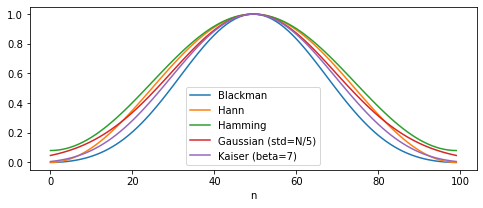

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

N = 100

ax.plot(signal.blackman(N), label="Blackman")
ax.plot(signal.hann(N), label="Hann")
ax.plot(signal.hamming(N), label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5)")
ax.plot(signal.kaiser(N, 7), label="Kaiser (beta=7)")

ax.set_xlabel("n")
ax.legend(loc=0)

다른 윈도우 함수들은 모두 약간씩 다른 속성과 목적을 갖고 있지만 대부분 서로 교체해 사용할 수 있다. 윈도우 함수의 주요 목적은 샘플링 주기와 정확히 구분되지 않는 신호 구성 요소를 가진 신호를 DFT할 경우에 발생하는 주파수 빈(bin) 사이의 스펙트럼 누출을 줄이는 것이다. 따라서 그런 주파수를 가진 신호 구성 요소는 샘플링 주기의 전체 사이클 수에 맞지 않을수 있으며 DFT는 신호가 주기라고 가정하므로 주기 경계에서 발생하는 불연속성은 스펙트럼 누출을 야기할 수 있다. 신호와 윈도우 함수가 곱해지면 이 문제를 줄일 수 있다. 또는 더 높은 주파수 분해능을 얻기 위해 표본 포인트 수를 늘릴 수도 있지만(샘플링 주기를 증가), 이 방법이 항상 실용적이지 않을 수도 있다.

FFT를 시계열 신호에 적용하기 전에 윈도우 함수를 어떻게 사용하는지 알아보기 위해
12장에서 살펴봤던 실외 온도 측정을 다시 살펴보자. 먼저 Pandas 라이브러리를 사용해 데이터셋을 로드한 후 시간 단위 표본을 위해 등간격으로 재표본한 후 fillna 메서드를 시용해 요소를 집계한다.

In [13]:
df = pd.read_csv('temperature_outdoor_2014.tsv', delimiter="\t", names=["time", "temperature"])
df.time = pd.to_datetime(df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm')
df = df.set_index("time")
df = df.resample("H").ffill()
df = df[(df.index >= "2014-04-01")*(df.index < "2014-06-01")].dropna()

Pandas DataFrame이 생성되고 처리되면 fftpack 모률을 사용해 시계열 데이터를 처리할 수 있도록 기본 Numpy 배열을 추출한다.

In [14]:
time = df.index.astype('int64')/1.0e9
temperature = df.temperature.values

이제 FFT를 계산하기 전에 temperature 배열 데이터에 윈도우 함수를 적용한다. 여기서는 스펙트럼 누출을 줄이는 데 적합한 윈도우 함수인 블랙만 윈도우 함수를 이용한다. 블랙만 함수는 Scipy의 signal 모률에 blackman 함수로 구현돼 있다. 윈도우 함수의 인수로 표본 배열의 길이를 전달해야 하고, 같은 길이의 배열이 반환된다.

In [15]:
window = signal.blackman(len(temperature))

윈도우 함수를 적용하려면 시간-영역 신호를 포함한 배열을 곱하고 그 결과를 후속 FFT 계산에 사용해야 한다. 그러나 온도 신호에 대한 FFT를 진행하기 전에 원래의 온
도 시계열과 윈도우된 버전을 표시해보자. 결과는 아래와 같다. 시계열을 윈도우 함수와 곱한 결과는 샘플링 주기 경계 부근에서 0에 근접하는 신호로 주기 경계 간 전환이 원활한 주기 함수로 볼 수 있고， 따라서 윈도우된 신호의 FFT의 특성이 좋아진다.

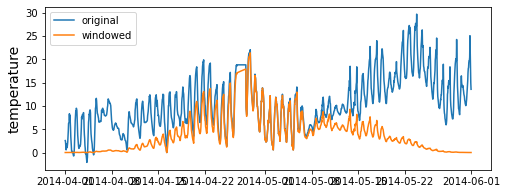

In [16]:
temperature_windowed = temperature * window

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(df.index, temperature, label="original")
ax.plot(df.index, temperature_windowed, label="windowed")

ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

윈도우된 신호가 준비되면 나머지 스펙트럼 분석은 전과 같이 진행된다 fft 함수를 사용해 스펙트럼을 계산하고 fftfreq 함수를 사용해 각 주파수 빈(bin)에 해당하는 주파수를 계산한다.

In [17]:
data_fft_windowed = fftpack.fft(temperature_windowed)
f = fftpack.fftfreq(len(temperature), time[1]-time[0])

여기서도 배열 f에서 마스크 배열을 생성해 양의 주파수를 선택하고 그 결과 발생하는 양의 주파수 스펙트럼을 아래 그림과 같이 도식화했다. 그림의 스펙트럼은 하루(1/86400Hz)에 해당하는 주파수의 피크와 그 상위 조화파(harmonics, 2/86400Hz, 3/86400Hz 등)를 명확히 보여주고 있다. 

Text(0.5, 0, 'frequency (Hz)')

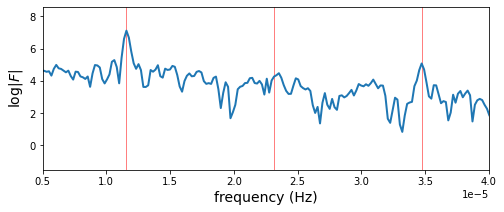

In [18]:
mask = f > 0

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)

ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])), lw=2)

ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)

주어진 표본 집합에서 가장 정확한 스펙트럼을 얻기 위해서는 일반적으로 FFT를 적용하기 전에 시계열 신호에 윈도우 함수를 적용하는 것이 바람직하다. Scipy에서 이용할 수 있는 대부분의 윈도우 함수는 서로 교체해 사용할 수 있으며 윈도우 함수의 종류는 중요하지 않다. 보편적인 선택은 스펙트럼 누출을 최소화하도록 설계된 블랙만 윈도우 함수다.

## 스펙트로그램
스펙트럼 분석에 관한 마지막 예로서 여기서는 기타 악기에서 표본 추출된 오디오 신호의 스펙트럼을 분석해본다. 먼저 Scipy 라이브러리의 io.wavefile.read 함수를 사용해 guitar.wav 파일의 표본된 데이터를 로드한다.

In [19]:
sample_rate, data = io.wavfile.read("guitar.wav")

io.waveftle.read 함수는 샘플링 속도 sample_rate가 들어 있는 튜플과 오디오 강도가 포함된 Numpy 배열을 반환한다. 이 특정 파일의 경우 샘플링 속도는 44.1kHz 이고 오디오 신호는 2개의 채널이 있는 데이터 배열로 표현된 스테레오로 기록돼 있다. 각 채널은 1181625개의 표본을 갖고 있다.

In [20]:
print("sample_rate: ", sample_rate)
print("data.shape: ", data.shape)

sample_rate:  44100
data.shape:  (1181625, 2)


여기서는 단일 오디오 채널만 분석할 것이므로 두 채널의 평균으로 단일 채널 신호를 만든다.

In [21]:
data = data.mean(axis=1)

표본 수를 샘플링 속도로 나누면 오디오 녹음의 총 지속 시간을 계산할 수 있다. 녹음 시간은 약 26.8초임을 알 수 있다.

In [22]:
data.shape[0] / sample_rate

26.79421768707483

신호의 특성상 긴 시간 척도에서는 변이가 심하지만 짧은 시간 구간에서 거의 주기적인 요소가 들어 있는 경우 등에는 대개 전체 선호의 스펙트럼을 한꺼번에 계산하지 않고 구역 단위로 스펙트럼을 계산한다. 짧은 시간 주기에서는 신호가 반복적인 것으로 느껴지지만, 음악과 같은 긴 시간 주기에서는 변화가 심하게 느껴진다. 따라서 기타 소리 표본의 경우, 시간-영역 신호에서 움직이는 윈도우에 FFT를 적용하고자 한다. 그 결과는 시간에 종속된 스펙트럼으로 음악 장비와 응용에서 종종 이퀄라이저(equalizer) 그래프로 시각화된다. 또 다른 접근법은 2차원 히트맵 그래프를 사용해 시간-종속 스펙트럼을 시각화하는 것인데 이 맥락에서 스펙트로그램(spectrogram)으로 불린다. 이제 기타 표본의 스펙트로그램을 계산해보자.

스펙트로그램을 시각화하기 전에 먼저 표본의 작은 부분에 대한 스펙트럼을 계산해보자. 우선 전체 표본 배열 중 사용할 표본의 수부터 결정한다. 만약 0.5초를 분석하고자 한다면 샘플링 속도를 이용해 사용할 표본 수를 계산할 수 있다.

In [23]:
N = int(sample_rate/2.0) # 0.5초 -> 22050 표본

표본 수와 샘플링 속도가 정해지면 FFT 계산 결과 주파수 빈(bin)의 주파수 f와 각 시간-영역 신호의 표본의 샘플링 시간 t를 계산할 수 있다. 또 1,000Hz 미만의 양의 주파수를 선택하기 위한 주파수 마스크도 생성하는데, 이는 나중에 계산된 스펙트럼의 부분 집합을 선택하는데 사용할 것이다.

In [24]:
f = fftpack.fftfreq(N, 1.0/sample_rate)
t = np.linspace(0, 0.5, N)
mask = (f > 0) * (f < 1000)

다음으로 전체 표본배열 데이터에서 첫 번째 N개 표본을 추출하고 여기에 fft 함수를적용한다.

In [25]:
subdata = data[:N]
F = fftpack.fft(subdata)

시간 및 주파수-영역 신호는 아래와 같다. 왼쪽 패널에 보이는 시간-영역 신호의 첫 부분은 기타 줄이 튕겨지기 전으로, 최초에는 0으로 나타나 있다. 주파수-영역 스펙트럼은 기타에 의해 생성된 서로 다른 톤에 해당하는 지배적인 몇 개의 주파수가 보인다.

Text(0.5, 0, 'Frequency (Hz)')

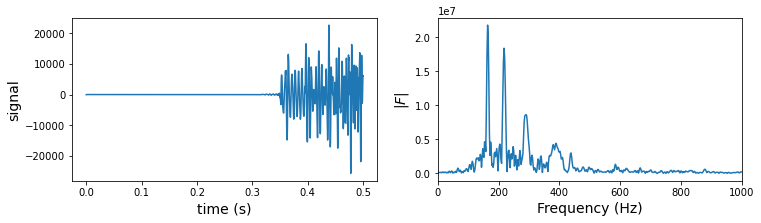

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)

axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)

다음 단계는 전체 표본 배열에서 연속 구간에 같은 분석을 반복하는 것이다. 스펙트럼의 시간상 변화는 주파수를 $x$축에 두고 시간을 $y$축에 둬 스팩토그램으로 시각화할 수 있다. Matplotlib의 imshow 함수로 스펙트럼을 도식화할 수 있도록 연속 표본 구간의 스펙트럼을 저장할 수 있는 2차원 Numpy 배열 spectrogram_data를 만든다. spectrogram_data 배열의 모양은 (n_max, f_values)이며, 여기서 n_max는 표본 배열 데이터의 길이 N의 구역, f_values는 마스크 계산에 사용된 조건(양의 주파수 1000Hz 미만)과 일치하는 주파수를 가진 주파수 빈(bin)의 개수다.

In [27]:
n_max = int(data.shape[0] / N)
f_values = np.sum(mask)
spectogram_data = np.zeros((n_max, f_values))

결과 스펙트로그램의 대비를 좀 더 뚜렷이 하기 위해 FFT를 계산하기 전 각 표본 데이터의 부분 집합에 블랙만 윈도우 함수를 적용한다. 여기서는 스펙트럼 누설 감소 특성 때문에 블랙만 윈도우 함수를 선택하지만 다른 많은 윈도우 함수도 이와 유사한 결괴를 생성한다. 윈도우 배열의 길이는 부분 데이터 배열의 길이와 같아야 하므로 그 길이를 블랙만 함수에 인수로 전달한다.

In [28]:
window = signal.blackman(len(subdata))

마지막으로 크기 N의 배열 슬라이스를 루프를 돌면서 표본의 각 세그먼트에 대한 스펙트럼을 계산하고 윈도우 함수를 적용하고 FFT를 계산한 후 spectrogram_data 배열에 관심 대상의 주파수 결과의 부분 집합을 저장한다. 

In [29]:
for n in range(0, n_max):
    subdata = data[(N * n):(N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spectogram_data[n, :] = np.log(abs(F[mask]))

spectrogram_data가 계산되면 Matplotlib의 imshow 함수를 사용해 스펙트로그램을 시각화할 수 있다. 결과는 아래 그림과 같다.

Text(0.5, 0, 'Frequency (Hz)')

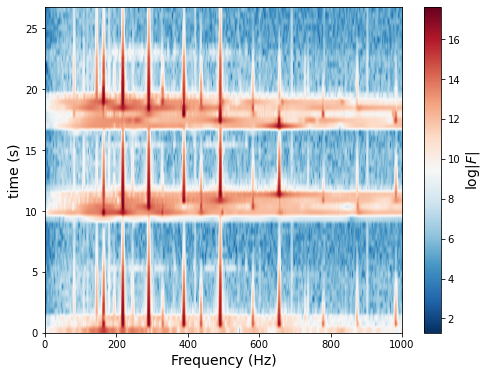

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

p = ax.imshow(spectogram_data, origin='lower',
              extent=(0, 1000, 0, data.shape[0] / sample_rate),
              aspect='auto',
              cmap=mpl.cm.RdBu_r)

cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=14)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)

그림의 스펙트로그램은 샘플링된 신호와 그 시간에 따른 변화에 대한 정보가 수록돼 있다. 좁은 수직 줄무늬는 기타가 만들어내는 음색에 해당하며, 이 신호는 시간이 갈
수록 서서히 쇠퇴한다. 넓은 수평 밴드는 기타 줄이 튕겨지는 시간 주기와 대략 일치한다. 그러나 색상 축은 로그 척도를 사용했으므로 색상의 작은 변화는 실제 강도에 있어서는 큰 변화를 의미한다는 점에 유의하자. 

# 신호 필터
신호 처리의 주 목적 중 하나는 시간 또는 공간 신호를 조작하고 변환해 그 특성을 바꾸는 것이다. 대표적인 응용으로는 잡음 감소, 오디오 신호의 음향 효과, 이미지 데이터의 번짐 효과, 선명하게 만들기, 대비 강화, 색 밸런스 조정 등이 있다. 많은 일반적인 변환은 특정 주파수 성분을 억제함으로써 신호의 주파수-영역 표현에 작용하는 필터를 사용해 구현될 수 있다. 앞에서는 신호의 푸리에 변환을 취해 고주파 성분을 제거한 후 최종적으로 역푸리에 변환을 취해 새로운 시간-영역 신호를 얻는 방식으로 구현한 저주파-통과 필터의 예를 살펴봤다. 이 방식으로 임의의 주파수 필터를 구현할 수 있지만 이 방법들은 DFT를 수행할 수 있을 만큼의 충분한 표본 버퍼링이 필요하기 때문에 실시간 스트리밍 신호에서는 적용하기가 쉽지 않을 수 있다. 많은 응용에서는 예를 들어 송신 중의 신호나 라이브 오디오 신호를 처리할 때는 연속적인 방식으로 필터를 적용하고 신호를 변환하는 것이 바람직하다.

## 컨볼루션 필터
특정 유형의 주파수 펼터는 필터의 특성을 나타내는 함수로 신호의 컨볼루션(convolution)을 이용해 시간 영역에서 직접 구현할수 있다. 푸리에 변환의 중요한특성은 2개의 함수(예를 들어 신호의 스펙트럼과 필터 형상 함수)의 곱의 (역)푸리에 변환은 2개의 함수의 (역)푸리에 변환의 컨볼루션이라는 것이다. 따라서 신호 $x_n$의 스펙트럼 $X_n$에 픽터 $H_k$를 적용하려면 필터 함수 $H_k$의 역푸리에 변환 $h_m$으로 $x_m$의 컨볼루션을 계산할 수 있다. 일반적으로 컨볼루션 형태의 필터는 다음과 같이 나타낼 수 있다.
$$y_n=\sum_{k=-\infty}^{\infty}x_kh_{n-k},$$
- $x_k$: 입력
- $y_n$: 출력
- $h_{n-k}$: 필터를 특성화하는 컨볼루션 커널

시간 단계 $n$에서의 신호 $y_n$은 입력 $x_k$의 이전과 이후 값에 따라 달라진다. 이 점을 알아보기 위해 이 페이지의 첫 번째 예시, 즉 시율레이션된 1Hz와 22Hz의 구성 요소에 저주파-통과 필터를 적용했던 예로 돌아가보자. 그 예에서는 신호를 푸리에 변환하고 그 스펙트럼을 모든 고주파 성분을 억제하는 단계 함수로 곱했고, 마지막으로 신호를 역푸리에 변환해 다시 시간-영역으로 되돌렸다. 그 결과는 원래 잡음이 있는 신호의 평활화 버전이었다. 컨볼루션을 이용한 대안적 방법은 필터 H의 주파수 응답 함수를 역푸리에 변환하고 결과 h를 커널로 사용해 원래 시간-영역 신호 f_t를 컨볼루션 하는 것이다.

In [31]:
N = int(f_s / delta_f)
f = fftpack.fftfreq(N, 1/f_s)

t = np.linspace(0, T, N)
f_t = signal_samples(t)
H = abs(f) < 2
h = fftpack.fftshift(fftpack.ifft(H))
f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

컨볼루션을 수행하기 위해 여기서는 Scipy의 signal 모률의 convolve 함수를 시용했다. convolve 함수는 인수로서 컨볼루션을 계산할 2개의 Numpy 배열을 취한다. 

__<center>mode 인수 종류</center>__
- same: 출력 배열의 크기를 첫 번째 입력으로 설정
- full: 과도(transients)를 고려하기 위해 0으로 패딩한 후 전체 컨볼루션을 출력
- valid: 패딩되지 않은 요소만 포함

여기서는 mode='same'으로 설정해 결과를 원래의 신호인 f_t와 쉽게 비교하고 도식화할 수 있다. 이 컨볼루션 필터인 f_t_filtered_conv를 적용한 결과는 수정 스펙트럼(f_t_filtered)에 fft와 ifft를 사용해 계산한 해당 결과와 함께 아래 그림에 표시돼 있다. 예상한 대로 두 방법은 동일한 결과를 생성했다.

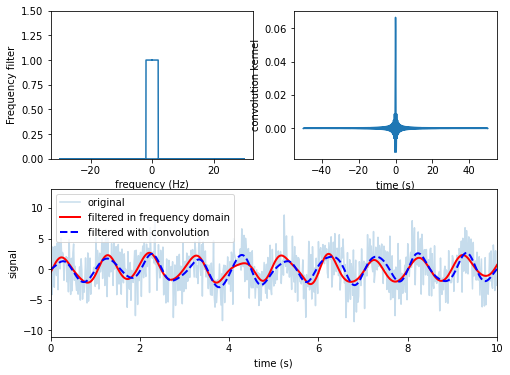

In [32]:
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - t[-1]/2.0, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real, "r", lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')

ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

## FIR 및 IIR 필터
앞 절의 컨볼루션 필터의 예에서는 일련의 fft를 호출하고 스펙트럼을 수정한 후 iftt를 호출하는 대신 컨볼루션을 구현한다고 해서 특별히 계산상의 이점을 보지는 못했다. 실제로 여기에서의 컨볼루션은 일반적으로 다른 FFT 변환보다 계산양이 더 이 요구되며 Scipy signal 모듈에는 실제로 FFT와 그 역을 이용해 컨볼루션을 구현해둔 함수 fftconvolve가 있다. 더욱이 필터의 컨볼루션 커널은 출력 신호가 입력의 미래 값에 종속되는 난캐주얼(noncasual) 등의 바람직하지 못한 속성을 갖고 있다(위 그림의 오른쪽 위 패널 참조). 그러나 전용 디지털 신호 처리기(DSP)와 범용 처리기로 구현할 수 있는 중요한 특수 경우가 있다. 이러한 필터 중 중요한 패밀리는 $y_n=\sum_{k=0}^{M}b_kx_{n-k}$의 형태를 취하는 유한 임펄스 반응(finite  impulse response. FIR) 필터다. 이 시간-영역 필터는출력 $y_n$이 초기 단계의 입력값에만 종속되기 때문에 캐주얼하다.

또 다른 유사한 형태의 필터는 무한 임펄스 반응(IIR) 필터로, $a_0y_n=\sum_{k=0}^{M}b_kx_{n-k}-\sum_{k=1}^{N}a_ky_{n-k}$ 유형으로 나타낼 수 있다. 이 필터는 새로운 출력값(피드백 항)을 계산할 때 출력의 과거 값을 추가로 포함하므로 엄밀히 말해 컨볼루션은 아니지만 유사한 형태를 갖고 있다. FIR 필터와 IIR 필터는 모두 최근 신호 이력과 출력이 주어지면 새로운 신호 값을 계산할 수 있고, $b_k$와 $a_k$ 값의 유한 시퀀스를 안다면 시간-영역에서 순차적으로 계산할 수 있다.

필터 성질에 일련의 요구 사항이 주어졌을 때 그에 따른 $b_k$와 $a_k$의 값을 계산하는 것을 필터 설계라고 한다. Scipy signal 모듈은 이러한 목적을 위해 많은 함수를 제공한다. 예를 들어 firwin 함수를 사용하면 주어진 밴드 경계의 주파수로(여기서 필터는 (저주파-통과 필터의 경우) 패스-필터에서 스톱-필터로 바뀐다) FIR 필터의 $b_k$ 계수를 계산할 수 있다. firwin 함수는 $a_k$ 시퀀스의 값 개수를 첫 번째 인수로 취한다(이 맥락에서 탭(taps)이라고도 함). 두 번째 인수인 cutoff는 저주파 변환 주파수를 나이키스트(Nyquist) 주파수 단위(샘플링 속도의 절반)로 정의한다. 나이키스트 주파수의 크기는 nyq 인수를 사용해 선택적으로 설정할 수 있으며 기본값은 1이다. 마지막으로 window 인수를 사용해 윈도우 함수 유형을 지정할 수 있다. 

In [33]:
n = 101
f_s = 1 / 3600
nyq = f_s / 2
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

결과는 FIR 필터를 정의하는 일련의 계수 $b_k$인데, 이 값은 시간-영역 컨볼루션 필터를 구현할 때 사용할 수 있다. 계수 $b_k$가 주어지면 signal 모듈의 freqz 함수를 사용해 필터의 진폭과 위상 응답을 계산할 수 있다. freqz 함수는 아래 그림과 같이 도식화하기에 적절한 주파수와 해당 복소수 주파수 응답이 있는 배열을 반환한다.

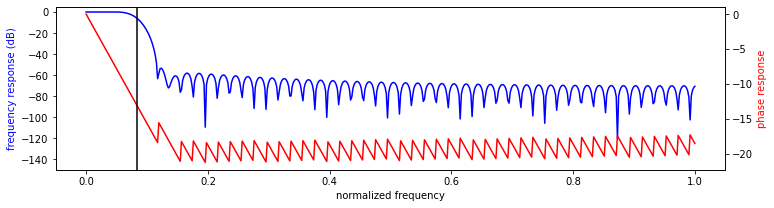

In [34]:
f, h = signal.freqz(b)


fig, ax = plt.subplots(1, 1, figsize=(12, 3))

h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')

ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')

ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase response', color="r")
ax.axvline(1.0/12, color="black")

위 그림에 나타난 저주파-통과 필터는 $f_s/24$(수직선으로 표시) 미만의 주파수로 신호를 통과시키고 고주파수 신호 구성 요소를 억제하도록 설계돼 있다. 통과와 정지 밴드 사이의 유한한 크기의 전환 지역과 컷오프 주파수 이상을 완벽히 억제하지 못하는 것은 FIR 형태의 필터를 사용할 때 치러야할 대가다. FIR 필터의 정확도는 계산 복잡도를 높여 계수 $b_k$의 개수를 증가시키면 개선할 수 있다.

계수 $b_k$가 주어졌을 때 FIR 필터의 효과와 계수 $b_k$와 $a_k$가 주어졌을 때 IIR 필터의 효과는 signal 모듈의 lfilter 함수를 사용해 계산할 수 있다 lfilter 함수의 첫 번째 인수는 계수 $b_k$값을 가진 배열, 두 번째 인수는 IIR 필터의 경우에는 계수 $a_k$의 배열이고, FIR 필터의 경우에는 스칼라 값 1이다. 세 번째 인수는 입력 신호 배열이며 반환값은 필터 출력이다. 예를 들어 앞서 생성한 FIR 필터를 시간당 온도 측정 배열 temperature에 적용하려면 다음과 같이 할 수 있다.

In [35]:
temperature_filt = signal.lfilter(b, 1, temperature)

저주파-통과 FIR 필터를 신호에 적용한 효과는 아래 그림과 같이 고주파 진동을 제거
해 함수를 평활화하는 것이다. 유사한 결과를 얻을 수 있는 또 다른 방법은 출력이 가중 평균이거나 몇몇 입력값의 중앙값을 사용하는 이동 평균 필터를 적용하는 것이다. signal 모듈의 함수 medfilt는 주어진 입력 신호로 중앙값 필터를 적용하는데, 과거 주변 값의 개수를 지정하려면 두 번째 인숫값을 설정해야 한다.

In [36]:
temperature_median_filt = signal.medfilt(temperature, 25)

FIR 저주파-통과 필터를 시간당 온도 측정 데이터셋에 적용한 결과는 다음과 같다. FIR 필터의 출력은 FIR 필터의 탭 수에 해당하는 시간 지연만큼 원래 신호에서 이동
된다는 점에 유의하자. medfilt를 사용해 구현된 중앙값 필터는 그 중앙값이 과거와 미래 값 모두 계산됐으므로 이러한 문제가 없다. 이 때문에 중앙값 필터는 스트리밍 입력 데이터를 실시간으로 계산할 수 없는 난캐주얼 필터가 된다. 

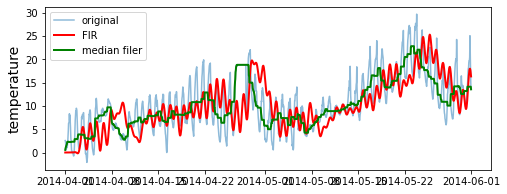

In [37]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filt, color="red", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filt, color="green", lw=2, label="median filer")

ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

IIR 필터를 설계하기 위해 signal 모률의 iirdesign 함수를 사용하거나 버터 워스(Butterworth) 필터(signal.butter), 체비셰프(Chebyshev) Ⅰ, Ⅱ 필터(signal.cheby1과 signal.cheby2), 타원형 필터(signal.ellip) 등 미리 정의된 다양한 IIR 필터 중 하나를 사용할 수 있다. 예를 들어 저주파는 억제하면서 임계(critical) 주파수 7/365Hz 이상의 주파수는 통과시키는 버터워스 고주파-통과 필터를 생성하는 방법은 다음과 같다.

In [38]:
b, a = signal.butter(2, 7/365.0, btype='high')

이 함수의 첫 번째 인수는 버터워스 필터의 차수, 두 번째 인수는 필터의 임계 주파수(밴드스톱에서 밴드패스 함수로의 이동)다. 옵션 인수 btype은 필터가 저주파-통과 필터(low)인지, 고주파-통과 필터(high)인지를 지정하는 데 사용된다. 보다 많은 함수 옵션은 help(signal.butter) 등의 docstring를 참고. 출력 a와 b는 각각 IIR 필터를 정의하는 $a_k$ 및 $b_k$ 계수다. 여기서는 2차 버터워스 필터를 계산했으므로 a와 b는 각각 다음과 같은 세 가지 요소를 갖고 있다.

In [39]:
print("b: ", b)
print("a: ", a)

b:  [ 0.95829139 -1.91658277  0.95829139]
a:  [ 1.         -1.91484241  0.91832314]


이전처럼 필터를 적용할 수 있다(여기서 다시 시간당 온도 데이터셋 예제 사용)

In [40]:
temperature_iir = signal.lfilter(b, a, temperature)

또는 filtfilt 함수를 사용해도 필터를 전후방 모두 적용해 난캐주얼 필터를 생성할 수 있다.

In [41]:
temperature_filtfilt = signal.filtfilt(b, a, temperature)

두 필터 유형의 결과는 아래 그림과 같다. 저주파 성분을 제거하면 시계열은 추세가 감소하며 고주파수 진동과 파동만 유지된다. 따라서 필터링된 신호는 원래 신호의 변동성을 측정하는 것으로 볼 수 있다. 이 예에서 일별 변화는 1월과 2월의 겨울과 비교했을 때 3월, 4월, 5월의 봄에 더 크다는 것을 알 수 있다.

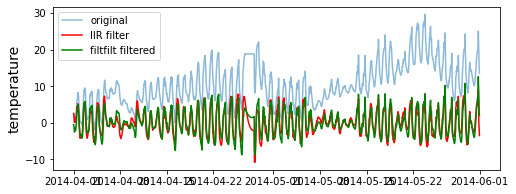

In [42]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_iir, color="red", label="IIR filter")
ax.plot(df.index, temperature_filtfilt, color="green", label="filtfilt filtered")

ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)

이러한 기법은 오디오 및 이미지 데이터에 직접 적용할 수 있다. 예를 들어 기타 표본의 오디오 신호에 필터를 적용하기 위해서는 lfilter 함수를 사용할 수 있다. FIR 필터의 $b_k$는 때때로 수동으로 구성할 수 있다. 예를 들어 간단한 에코 사운드 효과를 적용하려면 과거 신호를 일정 시간 지연으로 반복하는 FIR 필터를 만들 수 있다($y_n=x_n+x_{n-N}$). 여기서 $N$은 시간 단계 단위로 된 지연 시간이다. 해당 계수 $b_k$는 쉽게 구성되며 오디오 신호 data에 적용할 수 있다.

In [43]:
b = np.zeros(5000)
b[0] = b[-1] = 1
b /= b.sum()
data_filt = signal.lfilter(b, 1, data)

수정된 오디오 신호를 들을 수 있도록 Scipy의 io.wavefile 모률에 있는 write 함수를 사용해 WAV 파일로 저장할 수 있다.

In [44]:
io.wavfile.write("guitar-echo.wav",
                 sample_rate,
                 np.vstack([data_filt, data_filt]).T.astype(np.int16))

이와 유사하게 signal 모듈의 도구를 사용해 많은 종류의 이미지 처리 필터를 구현할 수 있다. Scipy 는 ndimage 모듈이 제공되며 이에는 차원 영상 데이터에 특화된 많은 일반적인 영상 조작 함수와 필터가 포함돼 있다. Scikit-Image 라이브러리에는 Python으로 이미지를 처리하기 위한 고급 프레임워크가 제공된다.

# 요약
신호 처리는 대부분의 이공계 분야에서 응용되는 매우 광범위한 분야다. 여기서는 그중 신호 처리의 몇 가지 기본 응용만 다뤘으며 Python 계산 기법을 사용해 이런 문제를 해결하는 방법을 소개했고 과학 컴퓨팅을 위해 Python 생태계 내에서 이용할 수 있는 라이브러리 및 도구들을 설명하는 데 초점을 맞췄다. 특히 Scipy 라이브러리의 signal 모듈을 이용해 신호를 FFT해 시간-종속 신호의 스펙트럼 분석을 살펴봤고 선형 필터의 설계와 적용을 알아봤다.